In [1]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
# # If the above command is too slow, uncomment the following and try it
# !wget -q https://big.csr.unibo.it/downloads/bbs-dm/spark-3.5.1-bin-hadoop3.tgz
# !tar xf spark-3.5.1-bin-hadoop3.tgz
!pip3 install -q findspark


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/temurin-22.jdk/Contents/Home"
os.environ["SPARK_HOME"] = "./spark-3.5.1-bin-hadoop3"
import findspark
findspark.init()
findspark.find() # Should return '/content/spark-3.5.1-bin-hadoop3'

'./spark-3.5.1-bin-hadoop3'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
sc = spark.sparkContext

sc

24/06/19 15:09:10 WARN Utils: Your hostname, Joses-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.16.1.246 instead (on interface en0)
24/06/19 15:09:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/19 15:09:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local appName=Colab>

# MovieLens

[MovieLens](https://grouplens.org/datasets/movielens/) is a dataset about movies and ratings. You are working with two files:

- ml-movies.csv: contains details about the movies
  - Each movie is identified by ```movieId```
  - The title of the movie contains the information about the year of publication
- ml-ratings-1m.csv: contains 1 million ratings (in a range from 1 to 5) given by users to movies
  - Each rating is identified by ```movieId``` and ```userId```
  - Each rating is associated to a timestamp in milliseconds (e.g., 1256677221000)

Your goal is to create a single file representing the following cube.

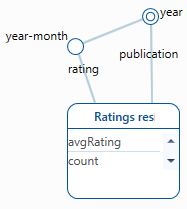

The procedure to create the cube is the following.

1. On the ml-movies.csv file:
  - Each line represents a movie, and the title includes the year of publication in the end, between parenthesis. We want to extract the year from the title. To do so:
    - Use the ```mycolumn.substr(start,number_of_chars)``` to isolate the year; remember that a negative ```start``` can be used to start from the end of the string
    - Cast the result to ```int```
    - Drop records with null values
2. On the ml-ratings-1m-v2.csv:
  - Get rid of the userId column
  - Convert the decimal character from comma to dot (as done during class)
  - Convert the timestamp from milliseconds to seconds by dividing the original value by 1000
  - Convert the timestamp in seconds to the "yyyy-MM" format to obtain the month, and to the "yyyy" format to obtain the year; to do so, use the ```from_unixtime(dfRatings['my_column'],"mydateformat")``` to convert from timestamp to the format of your choice
3. Join the two datasets on the ```movieId```
4. Aggregate the data by year-month, year, and publicationYear to calculate the average rating and count the records
5. Save the result to a file

In [3]:
!wget https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/datasets/ml-movies.csv
!wget https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/datasets/ml-ratings-1m-v2.csv

--2024-06-19 15:09:12--  https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/datasets/ml-movies.csv
A resolver raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
A ligar a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... ligado.
Pedido HTTP enviado, a aguardar resposta... 200 OK
Tamanho: 2800082 (2,7M) [text/plain]
A gravar em: "ml-movies.csv.1"

ml-movies.csv.1     100%[===================>]   2,67M  13,3MB/s    em 0,2s    

2024-06-19 15:09:12 (13,3 MB/s) - "ml-movies.csv.1" gravado [2800082/2800082]

--2024-06-19 15:09:12--  https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/datasets/ml-ratings-1m-v2.csv
A resolver raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
A ligar a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... ligado.
Pedido HTTP enviado, a aguardar resposta...

In [39]:
from pyspark.sql.functions import *
import datetime

## Spark

1. On the ml-movies.csv file:
  - Each line represents a movie, and the title includes the year of publication in the end, between parenthesis. We want to extract the year from the title. To do so:
    - Use the ```mycolumn.substr(start,number_of_chars)``` to isolate the year; remember that a negative ```start``` can be used to start from the end of the string
    - Cast the result to ```int```
    - Drop records with null values

In [40]:
# TODO
df_movies = spark.read.option("delimiter", ",").option("header", "true").csv("ml-movies.csv")
df_movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|                NULL|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|                NULL|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|                NULL|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [41]:
df_movies = df_movies.withColumn("year", df_movies.title.substr(-5, 4).cast("integer"))
df_movies = df_movies.na.drop(subset=["year"])
df_movies = df_movies.withColumnRenamed("year", "publicationYear")
df_movies.show()

+-------+--------------------+--------------------+---------------+
|movieId|               title|              genres|publicationYear|
+-------+--------------------+--------------------+---------------+
|      1|    Toy Story (1995)|Adventure|Animati...|           1995|
|      2|      Jumanji (1995)|Adventure|Childre...|           1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|
|      5|Father of the Bri...|              Comedy|           1995|
|      6|         Heat (1995)|Action|Crime|Thri...|           1995|
|      7|      Sabrina (1995)|                NULL|           1995|
|      8| Tom and Huck (1995)|  Adventure|Children|           1995|
|      9| Sudden Death (1995)|                NULL|           1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|           1995|
|     11|American Presiden...|Comedy|Drama|Romance|           1995|
|     12|Dracula: Dead and...|       Comedy|Horr

2. On the ml-ratings-1m-v2.csv:
  - Get rid of the userId column
  - Convert the decimal character from comma to dot (as done during class)
  - Convert the timestamp from milliseconds to seconds by dividing the original value by 1000
  - Convert the timestamp in seconds to the "yyyy-MM" format to obtain the month, and to the "yyyy" format to obtain the year; to do so, use the ```from_unixtime(dfRatings['my_column'],"mydateformat")``` to convert from timestamp to the format of your choice

In [42]:
# TODO
df_ratings = spark.read.option("delimiter", ";").option("header", "true").csv("ml-ratings-1m-v2.csv")
df_ratings.show()

+------+-------+------+-------------+
|userId|movieId|rating|    timestamp|
+------+-------+------+-------------+
|     1|    307|   3,5|1256677221000|
|     1|    481|   3,5|1256677456000|
|     1|   1091|   1,5|1256677471000|
|     1|   1257|   4,5|1256677460000|
|     1|   1449|   4,5|1256677264000|
|     1|   1590|   2,5|1256677236000|
|     1|   1591|   1,5|1256677475000|
|     1|   2134|   4,5|1256677464000|
|     1|   2478|     4|1256677239000|
|     1|   2840|     3|1256677500000|
|     1|   2986|   2,5|1256677496000|
|     1|   3020|     4|1256677260000|
|     1|   3424|   4,5|1256677444000|
|     1|   3698|   3,5|1256677243000|
|     1|   3826|     2|1256677210000|
|     1|   3893|   3,5|1256677486000|
|     2|    170|   3,5|1192913581000|
|     2|    849|   3,5|1192913537000|
|     2|   1186|   3,5|1192913611000|
|     2|   1235|     3|1192913585000|
+------+-------+------+-------------+
only showing top 20 rows



In [43]:
# drop userId col
df_ratings = df_ratings.drop("userId")
# convert the decimal from comma to integer
df_ratings = df_ratings.withColumn(
    "rating", regexp_replace(df_ratings.rating, ",", "\\.").cast("float")
)
# Convert the timestamp from milliseconds to seconds by dividing the original value by 1000
df_ratings = df_ratings.withColumn("timestamp", df_ratings.timestamp.cast("float") / 1000)
# Convert the timestamp from seconds to a month and a year
df_ratings = df_ratings.withColumn(
    "month", from_unixtime(df_ratings.timestamp, "yyyy-MM")
)
df_ratings = df_ratings.withColumn("year", from_unixtime(df_ratings.timestamp, "yyyy"))

df_ratings.show()

+-------+------+----------------+-------+----+
|movieId|rating|       timestamp|  month|year|
+-------+------+----------------+-------+----+
|    307|   3.5|1.256677179392E9|2009-10|2009|
|    481|   3.5|1.256677441536E9|2009-10|2009|
|   1091|   1.5|1.256677441536E9|2009-10|2009|
|   1257|   4.5|1.256677441536E9|2009-10|2009|
|   1449|   4.5|1.256677310464E9|2009-10|2009|
|   1590|   2.5|1.256677179392E9|2009-10|2009|
|   1591|   1.5|1.256677441536E9|2009-10|2009|
|   2134|   4.5|1.256677441536E9|2009-10|2009|
|   2478|   4.0|1.256677179392E9|2009-10|2009|
|   2840|   3.0|1.256677441536E9|2009-10|2009|
|   2986|   2.5|1.256677441536E9|2009-10|2009|
|   3020|   4.0|1.256677310464E9|2009-10|2009|
|   3424|   4.5|1.256677441536E9|2009-10|2009|
|   3698|   3.5|1.256677179392E9|2009-10|2009|
|   3826|   2.0|1.256677179392E9|2009-10|2009|
|   3893|   3.5|1.256677441536E9|2009-10|2009|
|    170|   3.5|1.192913534976E9|2007-10|2007|
|    849|   3.5|1.192913534976E9|2007-10|2007|
|   1186|   3

3. Join the two datasets on the ```movieId```

In [44]:
# TODO
joined_df = df_movies.join(df_ratings, on="movieId")
joined_df.show()

+-------+--------------------+--------------------+---------------+------+----------------+-------+----+
|movieId|               title|              genres|publicationYear|rating|       timestamp|  month|year|
+-------+--------------------+--------------------+---------------+------+----------------+-------+----+
|    307|Three Colors: Blu...|               Drama|           1993|   3.5|1.256677179392E9|2009-10|2009|
|    481|   Kalifornia (1993)|      Drama|Thriller|           1993|   3.5|1.256677441536E9|2009-10|2009|
|   1091|Weekend at Bernie...|              Comedy|           1989|   1.5|1.256677441536E9|2009-10|2009|
|   1257|Better Off Dead.....|      Comedy|Romance|           1985|   4.5|1.256677441536E9|2009-10|2009|
|   1449|Waiting for Guffm...|              Comedy|           1996|   4.5|1.256677310464E9|2009-10|2009|
|   1590|Event Horizon (1997)|Horror|Sci-Fi|Thr...|           1997|   2.5|1.256677179392E9|2009-10|2009|
|   1591|        Spawn (1997)|Action|Adventure|...|    

4. Aggregate the data by year-month, year, and publicationYear to calculate the average rating and count the records

In [45]:
# TODO
agg_joined_df = joined_df.groupBy("year", "month", "publicationYear").agg(
    {"rating": "avg", "movieId": "count"}
)
agg_joined_df.show()

+----+-------+---------------+------------------+--------------+
|year|  month|publicationYear|       avg(rating)|count(movieId)|
+----+-------+---------------+------------------+--------------+
|2000|2000-01|           1955|3.0869565217391304|            46|
|2012|2012-06|           1982| 3.685185185185185|            27|
|2016|2016-02|           2015|3.6146288209606987|           458|
|2001|2001-08|           1975|3.8421052631578947|            38|
|2000|2000-05|           2000|3.5277777777777777|           108|
|2011|2011-01|           1984|               3.0|            30|
|2013|2013-10|           1975| 4.136363636363637|            11|
|2014|2014-03|           2006|3.7413793103448274|            29|
|2015|2015-12|           1992| 3.477272727272727|            44|
|2004|2004-01|           1950|              4.05|            10|
|2012|2012-05|           2005|3.7555555555555555|            45|
|2002|2002-08|           1956|2.6666666666666665|             3|
|2001|2001-10|           

5. Save the result to a file

In [47]:
# TODO
agg_joined_df.write.csv("./ratings_cube")

In [ ]:
# hehe